# Solaris en Python
Agustín Vallejo Villegas

2-08-19

El siguiente programa toma componentes de otras simulaciones para crear una Aplicación de Reloj del Sistema Solar con datos reales.

Algunos arrays de utilidad:
+ **planetPos0:** Tiene la ubicación de los planetas para el día 2019-08-01. Ángulos en Radianes.
+ **planetPosT:** Tiene la misma ubicación de planetas pero con la Tierra en -90°.
+ **planetPosHoy:** Con la tierra en -90° muestra la ubicación actual de los planetas.
+ **rs:** Array con las distancias orbitales de Mercurio a Saturno.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import datetime
from astropy.time import Time
from astropy.coordinates import get_body_barycentric as gbb
from astropy.coordinates import SkyCoord as sky

In [3]:
def elipse(th,a,e,w): # Función Polar para la Distancia Radial en Función de Theta, Excentricidad, y Argumento del Periapsis
    th += w
    r = (a*(1-e**2))/(1-e*np.cos(th)) #Cálculo de Distancia Radial en Coord Polares
    return r

In [4]:
#Parámetros de las Órbitas del Sistema
#Tomados de http://www.met.rdg.ac.uk/~ross/Astronomy/Planets.html
planets = ['mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn']
planetColor = ['#aaaaaa','#ffcc4f','#28a9ff','#ff0000','#af6c00','#ffdd89'] #Colores
planetMajorAxis = [0.387 ,0.723 ,1     ,1.523 ,5.203 ,9.537] #Semiejes
planetExcentric = [0.2056,0.0068,0.0167,0.0934,0.0483,0.0541] # Excentricidades
planetLonPeriDeg = np.deg2rad([77.45,131.53,102.94,180   ,14.75 ,92.43]) #Argumento del Periapsis, la de Marte es en realidad 336 pero no cuadraba :(
planetPeriod = [365.25*a**(3/2) for a in planetMajorAxis] #Periodo de los planetas en días

In [8]:
planetPos0 = [] #Array que contendrá la ubicación de los planetas en la fecha t0

t0 = datetime.date(2019, 8, 1)
t1 = datetime.date.today()
# t1 = datetime.date(2000,1,1)
dt = t1 - t0
t = Time(str(t0))

#POSICIONES PLANETARIAS EN t0
for p in planets:
    S = sky(gbb(p,t)).transform_to('barycentrictrueecliptic')
    lon = np.deg2rad(S.lon.value)
    dis = S.distance.value
    planetPos0.append((lon,dis))
planetPos0 = np.array(planetPos0)

#POSICIONES MODIFICANDO MOVIMIENTO DE LA TIERRA EN t0
posEarth = planetPos0[2][0]
planetLonPeriT = np.zeros(6)
planetPosT = np.zeros((6,2))
for i in range(6): #Operación Opcional para poner la Tierra en -90°
    planetLonPeriT[i] = planetLonPeriDeg[i] - posEarth + np.pi*0.5
    planetPosT[i][0] = planetPos0[i][0] - posEarth - np.pi*0.5
    planetPosT[i][1] = planetPos0[i][1]
    
#POSICIONES EN t1 (HOY)
planetPosHoy = np.zeros((6,2)) #Posición del Planeta Hoy
for i in range(6): #Operación Opcional para poner la Tierra en -90°
    planetPosHoy[i][0] = planetPosT[i][0] + 2*np.pi*dt.days*((1/planetPeriod[i])-(1/planetPeriod[2]))
    planetPosHoy[i][1] = elipse(planetPosHoy[i][0],planetMajorAxis[i],planetExcentric[i],planetLonPeriT[i])
    
#VECTORIZAR POSICIONES RELATIVAS Y NORMALIZAR
for i in range(6):
    x = 6.030581306800926e-17
    y = 0.9848686676027165
    VecCart = [[v[1]*np.cos(v[0]),v[1]*np.sin(v[0])+y] for v in planetPosHoy] #Vector de Posición Geocéntrica
    planetAngHoy = [np.angle(v[0]+v[1]*1j) for v in VecCart]

**Explicación del Proceso Anterior:**

Funciones de *astropy* usadas:

`gbb = get_body_barycentric`

`sky = SkyCoord`

Procedimiento:

`gbb(p,t)` obtiene la ubicación de cada planeta en coordenadas cartesianas tridimensionales. Luego `sky()` las convierte a coordenadas ecuatoriales (RA,dec,dist). La función `transform_to` pasa de coordenadas ecuatoriales a eclípticas. Finalmente se extrae el valor numérico de la longitud eclíptica y la distancia en AU; se desprecia la latitud.

In [6]:
ths = np.linspace(0,2*np.pi,100) # Thetas
rs = np.zeros((6,100)) # Array vacío de Distancias
for i in range(100):
    for k in range(6):
        rs[k][i] = elipse(ths[i],planetMajorAxis[k],planetExcentric[k],planetLonPeriT[k]) # Para órbitas normales usar planetLonPeriDeg

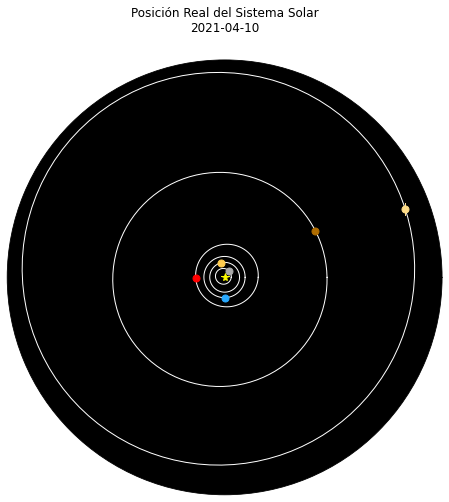

In [9]:
# Posiciones Reales del Sistema Solar el día de Hoy
plt.figure(figsize=(8,8))
for k in range(6):
    plt.polar(ths,rs[k],c='white',lw=1) #Órbita
    plt.polar(planetPosHoy[k][0],planetPosHoy[k][1],'o',c=planetColor[k],ms=7) #Punto del Planeta
    # Fijando la tierra en -90. Para los valores normales usar planetPos0.
    if k == 5:
        plt.polar(planetPosHoy[k][0],planetPosHoy[k][1],'|',c=planetColor[k],ms=12) #Anillos de Saturno
plt.polar(0,0,'*',c="#ffff00",ms=8) #Sol
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor('black')
plt.title("Posición Real del Sistema Solar\n"+ str(t1))
plt.show()

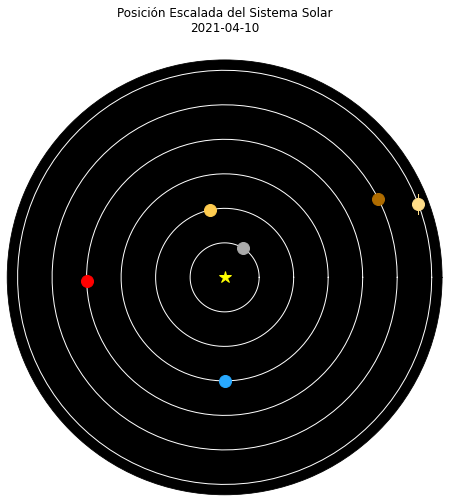

In [10]:
# Posiciones Escaladas del Sistema Solar Hoy
plt.figure(figsize=(8,8))
for k in range(6):
    plt.polar(ths,[k+1]*100,c='white',lw=1)
    plt.polar(planetPosHoy[k][0],k+1,'o',c=planetColor[k],ms=12)
    if k == 5:
        plt.polar(planetPosHoy[k][0],k+1,'|',c=planetColor[k],ms=20)
plt.polar(0,0,'*',c="#ffff00",ms=12)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor('black')
plt.title("Posición Escalada del Sistema Solar\n"+ str(t1))
plt.show()

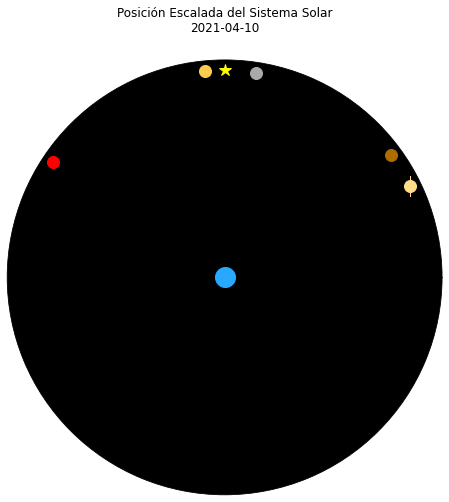

In [11]:
# Posiciones Aparentes del Sistema Solar Hoy
plt.figure(figsize=(8,8))
for k in range(6):
    if k == 2:
        plt.polar(planetAngHoy[k],0,'o',c=planetColor[k],ms=20)
        continue
    plt.polar(planetAngHoy[k],1,'o',c=planetColor[k],ms=12)
    if k == 5:
        plt.polar(planetAngHoy[k],1,'|',c=planetColor[k],ms=20)
plt.polar(0.5*np.pi,1,'*',c="#ffff00",ms=12)
# plt.polar(planetPosHoy[2][0],1,'x',c="#ffffff",ms=12)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
ax.set_facecolor('black')
plt.title("Posición Escalada del Sistema Solar\n"+ str(t1))
plt.show()